Credit Card Fraud Detection

INSTALL DEPENDENCIES (to be run only once in terminal)

In [2]:
# !pip install pandas numpy scikit-learn matplotlib seaborn lightgbm xgboost catboost
# !pip install imbalanced-learn kagglehub

IMPORT LIBRARIES

In [ ]:
# Data handling and basic utilities
import os
import kagglehub
import pandas as pd
import numpy as np
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Model Selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

# Traditional ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Boosting models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE

# Ignore warnings for clean output
import warnings
warnings.filterwarnings("ignore")


DATASET INTEGRATION

In [4]:
# Download the latest dataset version using kagglehub
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)

# Build full path to the CSV file
dataset_file = os.path.join(path, 'creditcard.csv')

# Load dataset
df = pd.read_csv(dataset_file)

# Basic Details
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())
print("\nColumn info:")
print(df.info())

Path to dataset files: C:\Users\ANKIT SARKAR\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3
Dataset shape: (284807, 31)

First 5 rows:
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005

EXPLORATORY DATA ANALYSIS

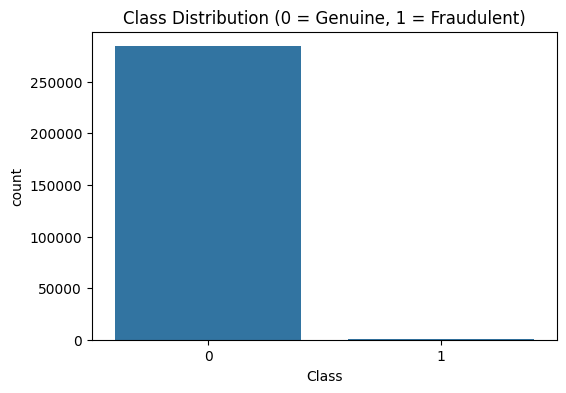

Fraudulent Transactions Ratio: 0.00173
Number of fraud transactions: 492
Sample fraud indices: [541, 623, 4920, 6108, 6329, 6331, 6334, 6336, 6338, 6427, 6446, 6472, 6529, 6609, 6641, 6717, 6719, 6734, 6774, 6820, 6870, 6882, 6899, 6903, 6971, 8296, 8312, 8335, 8615, 8617, 8842, 8845, 8972, 9035, 9179, 9252, 9487, 9509, 10204, 10484, 10497, 10498, 10568, 10630, 10690, 10801, 10891, 10897, 11343, 11710, 11841, 11880, 12070, 12108, 12261, 12369, 14104, 14170, 14197, 14211, 14338, 15166, 15204, 15225, 15451, 15476, 15506, 15539, 15566, 15736, 15751, 15781, 15810, 16415, 16780, 16863, 17317, 17366, 17407, 17453, 17480, 18466, 18472, 18773, 18809, 20198, 23308, 23422, 26802, 27362, 27627, 27738, 27749, 29687, 30100, 30314, 30384, 30398, 30442, 30473]


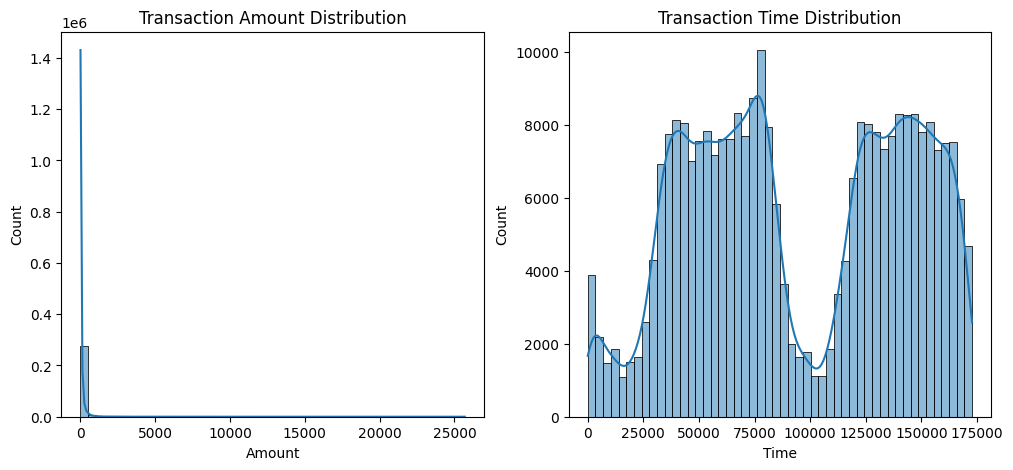

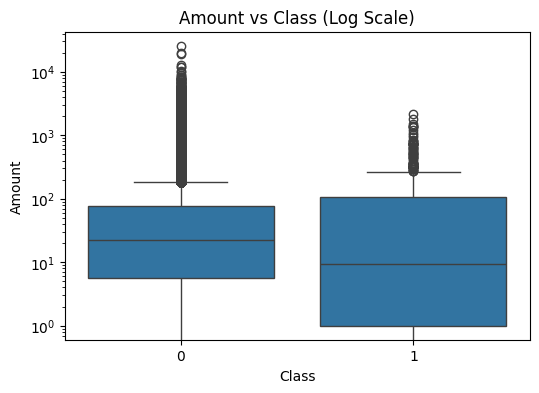

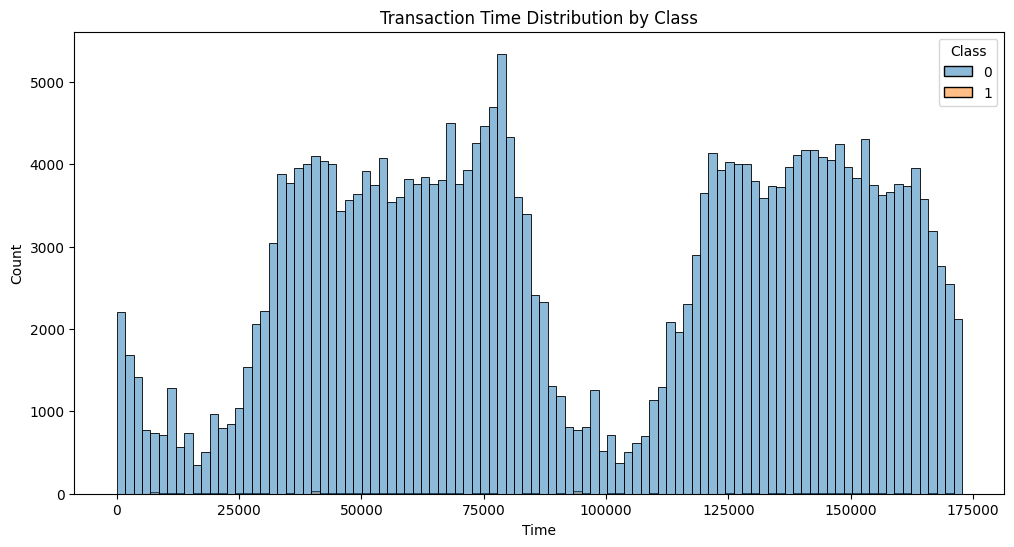

Feature Correlation with Class:
 Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64


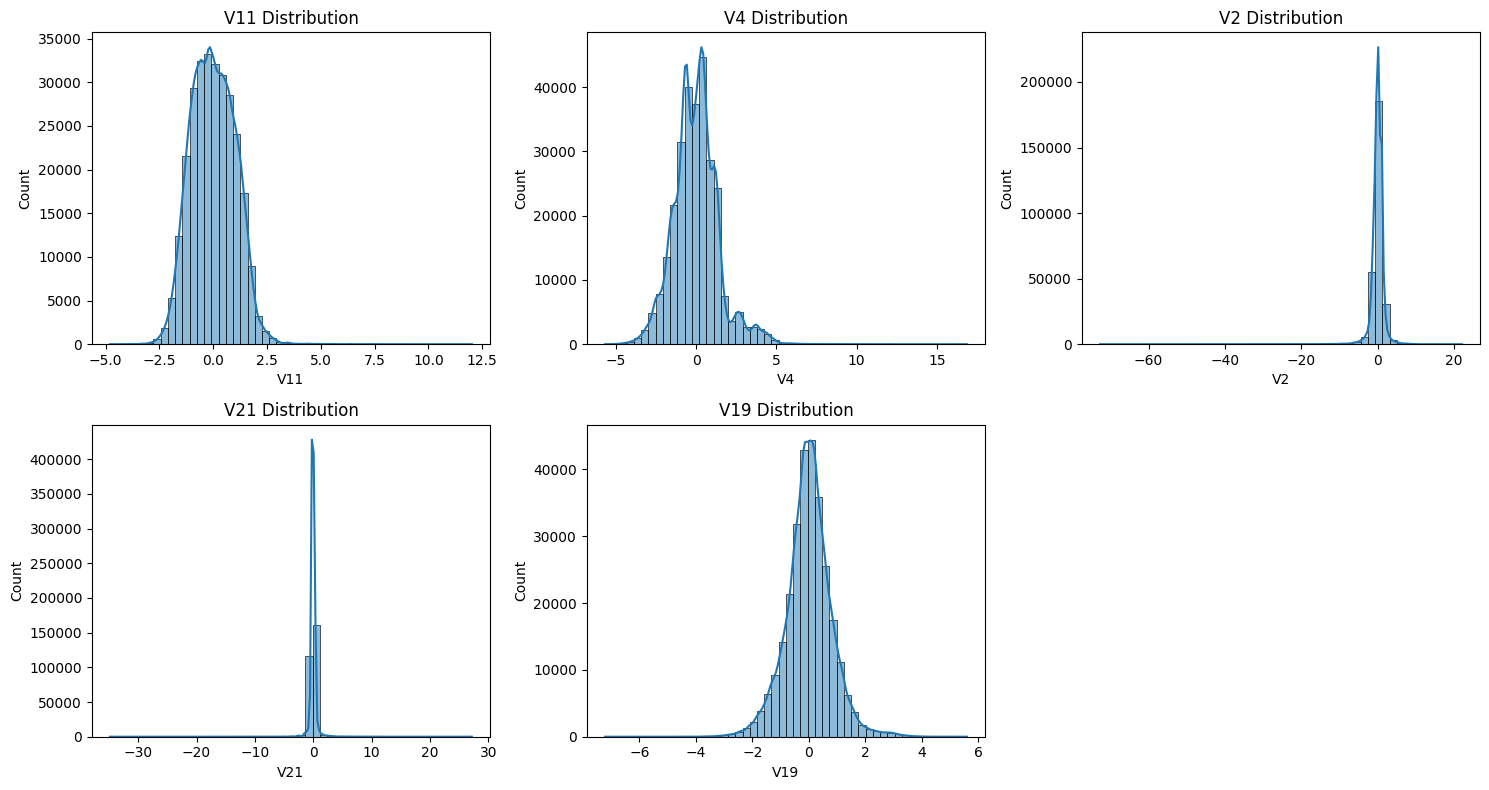

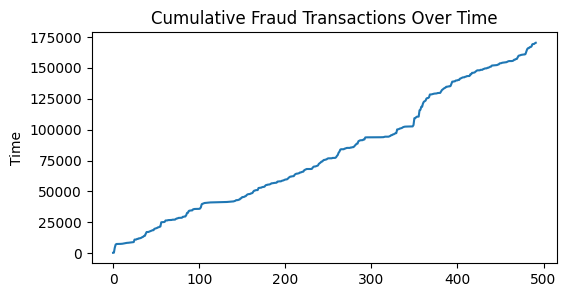

In [5]:
#  Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Genuine, 1 = Fraudulent)')
plt.show()

fraud_ratio = df['Class'].value_counts()[1] / df['Class'].value_counts().sum()
print(f"Fraudulent Transactions Ratio: {fraud_ratio:.5f}")

# Get indices of all frauds
fraud_indices = df[df['Class'] == 1].index.tolist()
print("Number of fraud transactions:", len(fraud_indices))
print("Sample fraud indices:", fraud_indices[:100])  # first 10 fraud indices

#  Feature Distributions: Amount and Time
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['Time'], bins=50, kde=True)
plt.title('Transaction Time Distribution')
plt.show()

# Amount vs Class
plt.figure(figsize=(6,4))
sns.boxplot(x='Class', y='Amount', data=df)
plt.yscale('log')
plt.title('Amount vs Class (Log Scale)')
plt.show()

# Time vs Class Analysis
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='Time', hue='Class', bins=100, kde=False, stat='count')
plt.title('Transaction Time Distribution by Class')
plt.show()

# Correlation of Features with Class
corr = df.corr()
corr_with_class = corr.loc[:, 'Class'].sort_values(ascending=False)
print("Feature Correlation with Class:\n", corr_with_class)

# Top 5 PCA Features most correlated with Class
top_pca_features = corr_with_class[1:6].index 
plt.figure(figsize=(15,8))
for i, col in enumerate(top_pca_features, 1):
    plt.subplot(2,3,i)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()

# Fraud Transactions Over Time
df_fraud = df[df['Class']==1].copy()
plt.figure(figsize=(6,3))
sns.lineplot(x=range(len(df_fraud)), y='Time', data=df_fraud)
plt.title('Cumulative Fraud Transactions Over Time')
plt.show()

DATA PROCESSING

In [6]:
# Split features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

# Feature Scaling for 'Amount' and 'Time'
scaler = StandardScaler()

X_train[['Amount', 'Time']] = scaler.fit_transform(X_train[['Amount', 'Time']])
X_test[['Amount', 'Time']] = scaler.transform(X_test[['Amount', 'Time']])

# Handle Class Imbalance with SMOTE (training set only)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(pd.Series(y_train_res).value_counts())


Training set shape: (227845, 30), Test set shape: (56962, 30)
Before SMOTE:
Class
0    227451
1       394
Name: count, dtype: int64

After SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


CLASS DISTRIBUTION AFTER 'SMOTE'

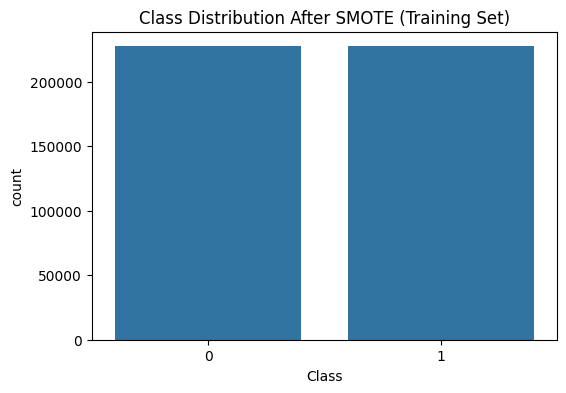

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_res)
plt.title("Class Distribution After SMOTE (Training Set)")
plt.show()


MODEL TRAINING AND EVALUATION

Training and evaluating Logistic Regression...
Model: LogisticRegression
Accuracy: 0.9742
Precision: 0.0580
Recall: 0.9184
F1-score: 0.1092


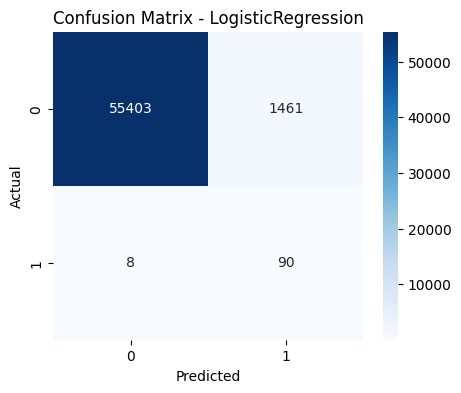

--------------------------------------------------
Training and evaluating Random Forest...
Model: RandomForestClassifier
Accuracy: 0.9995
Precision: 0.8454
Recall: 0.8367
F1-score: 0.8410


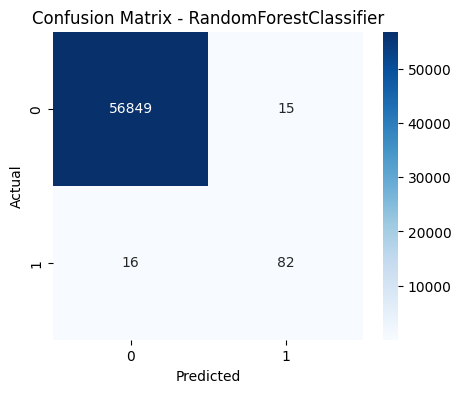

--------------------------------------------------
Training and evaluating XGBoost...
Model: XGBClassifier
Accuracy: 0.9992
Precision: 0.7311
Recall: 0.8878
F1-score: 0.8018


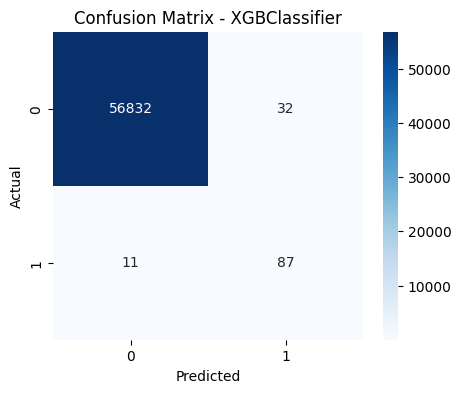

--------------------------------------------------
Training and evaluating LightGBM...
[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model: LGBMClassifier
Accuracy: 0.9982
Precision: 0.4913
Recall: 0.8673
F1-score: 0.6273


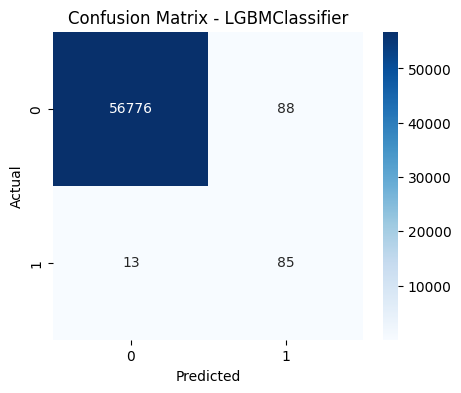

--------------------------------------------------
Training and evaluating CatBoost...
Model: CatBoostClassifier
Accuracy: 0.9990
Precision: 0.6615
Recall: 0.8776
F1-score: 0.7544


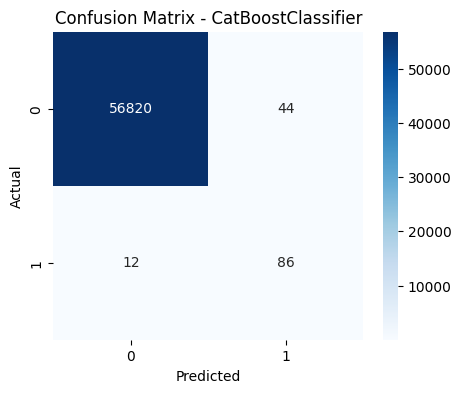

--------------------------------------------------

Model Comparison (sorted by F1-score):
                 Model  Accuracy  Precision    Recall  F1-score
1        Random Forest  0.999456   0.845361  0.836735  0.841026
2              XGBoost  0.999245   0.731092  0.887755  0.801843
4             CatBoost  0.999017   0.661538  0.877551  0.754386
3             LightGBM  0.998227   0.491329  0.867347  0.627306
0  Logistic Regression  0.974211   0.058027  0.918367  0.109157


In [8]:
# Dictionary to store models and their names
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
}

# Function to train and evaluate each model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print("Accuracy: {:.4f}".format(acc))
    print("Precision: {:.4f}".format(prec))
    print("Recall: {:.4f}".format(rec))
    print("F1-score: {:.4f}".format(f1))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print("-"*50)
    return acc, prec, rec, f1

# Store results
results = []

# Train and evaluate all models
for name, model in models.items():
    print(f"Training and evaluating {name}...")
    metrics = evaluate_model(model, X_train_res, y_train_res, X_test, y_test)
    results.append([name, *metrics])

# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"])
results_df.sort_values(by="F1-score", ascending=False, inplace=True)
print("\nModel Comparison (sorted by F1-score):")
print(results_df)


SAVE THE MODEL (BEST MODEL : RANDOM FOREST)

In [9]:
df = pd.read_csv('creditcard.csv')

# Save the best model
best_model = models['Random Forest']
joblib.dump(best_model, 'fraud_detection_model.pkl') # type: ignore

# Save the fitted scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the columns used for scaling
scaler_columns = ['Time', 'Amount']
joblib.dump(scaler_columns, 'scaler_columns.pkl')

print("✅ Model, scaler, and scaler column names saved successfully!")

✅ Model, scaler, and scaler column names saved successfully!


FINAL PREDICTION 

In [10]:
# Best model is Random Forest
best_model = models['Random Forest']

# Example: Predict on first 10 transactions of test set
X_sample = X_test.iloc[:10]
y_sample_true = y_test.iloc[:10]

# Predict classes and fraud probabilities
y_sample_pred = best_model.predict(X_sample)
y_sample_prob = best_model.predict_proba(X_sample)[:, 1]  # Probability of fraud (class 1)

# Display predictions
prediction_df = pd.DataFrame({
    "Transaction Index": X_sample.index,
    "Actual Class": y_sample_true.values,
    "Predicted Class": y_sample_pred,
    "Fraud Probability": y_sample_prob
})

print("\nSample Predictions:")
print(prediction_df)

# Test fraudulent transactions
fraud_samples = X_test[y_test == 1].iloc[:10] 
fraud_true = y_test[y_test == 1].iloc[:10]  

fraud_pred = best_model.predict(fraud_samples)
fraud_prob = best_model.predict_proba(fraud_samples)[:, 1]

fraud_df = pd.DataFrame({
    "Transaction Index": fraud_samples.index,
    "Actual Class": fraud_true.values,
    "Predicted Class": fraud_pred,
    "Fraud Probability": fraud_prob
})

print("\nFraud Sample Predictions:")
print(fraud_df)


Sample Predictions:
   Transaction Index  Actual Class  Predicted Class  Fraud Probability
0             263020             0                0               0.00
1              11378             0                0               0.00
2             147283             0                0               0.02
3             219439             0                0               0.00
4              36939             0                0               0.00
5             243438             0                0               0.00
6             259448             0                0               0.00
7              43800             0                0               0.00
8              66742             0                0               0.00
9              66499             0                0               0.00

Fraud Sample Predictions:
   Transaction Index  Actual Class  Predicted Class  Fraud Probability
0              77348             1                1               0.98
1             102442         

CUSTOM INPUT PREDICTION

In [11]:
# Example: New custom transaction (replace values with real data later)
new_transaction = {
    'Time': 123456.0,
    'V1': -1.359807,
    'V2': -0.072781,
    'V3': 2.536347,
    'V4': 1.378155,
    'V5': -0.338321,
    'V6': 0.462388,
    'V7': 0.239599,
    'V8': 0.098698,
    'V9': 0.363787,
    'V10': 0.090794,
    'V11': -0.551599,
    'V12': -0.617800,
    'V13': -0.991390,
    'V14': -0.311169,
    'V15': 1.468177,
    'V16': -0.470400,
    'V17': 0.207971,
    'V18': 0.025791,
    'V19': 0.403993,
    'V20': 0.251412,
    'V21': -0.018307,
    'V22': 0.277838,
    'V23': -0.110474,
    'V24': 0.066928,
    'V25': 0.128539,
    'V26': -0.189115,
    'V27': 0.133558,
    'V28': -0.021053,
    'Amount': 149.62
}

# Convert to DataFrame
new_transaction_df = pd.DataFrame([new_transaction])

# Scale 'Amount' and 'Time' exactly as training data
new_transaction_df[['Amount', 'Time']] = scaler.transform(new_transaction_df[['Amount', 'Time']])

# Predict class and fraud probability
predicted_class = best_model.predict(new_transaction_df)[0]
fraud_probability = best_model.predict_proba(new_transaction_df)[0][1]

# Display result
print(f"Predicted Class: {'Fraudulent (1)' if predicted_class == 1 else 'Genuine (0)'}")
print(f"Fraud Probability: {fraud_probability:.4f}")

# New Custom Transaction Example (Likely Fraud)
new_transaction2 = {
    'Time': 12093,
    'V1': -4.69679522444504,
    'V2': 2.69386747884008,
    'V3': -4.47513271259153,
    'V4': 5.4676845487781,
    'V5': -1.55675807549758,
    'V6': -1.54942028904253,
    'V7': -4.10421487278526,
    'V8': 0.553934075416293,
    'V9': -1.49846813107494,
    'V10': -4.59495176285009,
    'V11': 5.27550585077254,
    'V12': -11.3490285500915,
    'V13': 0.374549235103921,
    'V14': -8.13869488434773,
    'V15': 0.548570894168134,
    'V16': -6.65359434741365,
    'V17': -10.2467554066001,
    'V18': -4.19106626655491,
    'V19': 0.991486122257293,
    'V20': -0.158970548660611,
    'V21': 0.573898081112651,
    'V22': -0.0801627753981571,
    'V23': 0.318407817148194,
    'V24': -0.245862202650853,
    'V25': 0.338238431564141,
    'V26': 0.0322706213908033,
    'V27': -1.50845793363219,
    'V28': 0.608074682590101,
    'Amount': 0
}

# Convert to DataFrame
new_transaction2_df = pd.DataFrame([new_transaction2])

# Scale 'Amount' and 'Time' using the fitted scaler
new_transaction2_df[['Amount', 'Time']] = scaler.transform(new_transaction2_df[['Amount', 'Time']])

# Predict class and fraud probability
predicted_class = best_model.predict(new_transaction2_df)[0]
fraud_probability = best_model.predict_proba(new_transaction2_df)[0][1]

# Display result
print(f"Predicted Class: {'Fraudulent (1)' if predicted_class == 1 else 'Genuine (0)'}")
print(f"Fraud Probability: {fraud_probability:.4f}")

Predicted Class: Genuine (0)
Fraud Probability: 0.0100
Predicted Class: Fraudulent (1)
Fraud Probability: 1.0000
